In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential

In [2]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'rice_dataset',
    image_size = (256,256),
    batch_size = 32,
    shuffle = True
)

Found 75000 files belonging to 5 classes.


In [3]:
class_names = dataset.class_names
class_names

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

In [4]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 3 2 0 2 4 0 0 4 0 1 4 1 0 2 1 4 1 0 0 4 4 2 2 1 1 0 3 0 4 0]


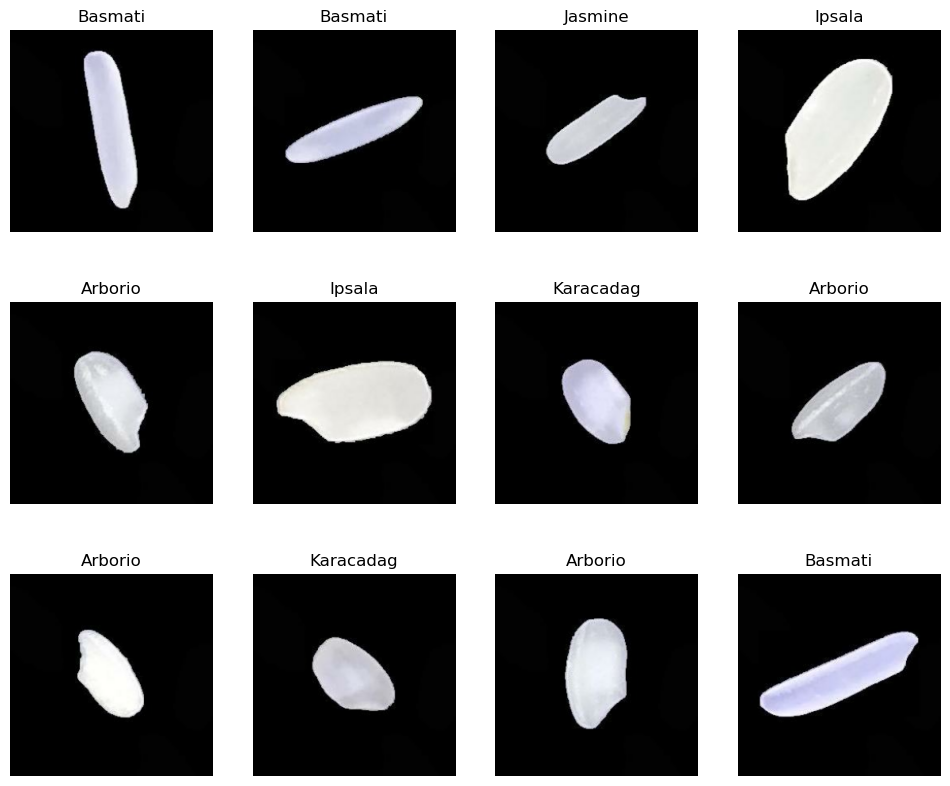

In [5]:
plt.figure(figsize=(12,10))
for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))  # Display the image
    plt.title(class_names[labels_batch[i].numpy()])  # Use label to fetch class name
    plt.axis('off') 
plt.show()

In [6]:
def split_dataset_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=500):
    assert(train_split+val_split+test_split)==1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    

    
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = split_dataset_tf(dataset)


In [7]:
# Data normalization
normalization_layer = tf.keras.layers.Rescaling(1. / 255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [8]:
data_agumentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

train_ds = train_ds.map(lambda x, y: (data_agumentation(x, training=True), y))

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# Model Architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(len(dataset.class_names), activation='softmax')  # Adjust output layer to match the number of classes
])


# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Change to 'categorical_crossentropy' if using one-hot encoding
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    batch_size=32
)

Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3619s 2s/step - accuracy: 0.7861 - loss: 0.5153 - val_accuracy: 0.6840 - val_loss: 1.1645
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4112s 2s/step - accuracy: 0.9322 - loss: 0.1851 - val_accuracy: 0.9060 - val_loss: 0.2678
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2034s 1s/step - accuracy: 0.9651 - loss: 0.1079 - val_accuracy: 0.9571 - val_loss: 0.1441
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19095s 10s/step - accuracy: 0.9814 - loss: 0.0603 - val_accuracy: 0.8994 - val_loss: 0.3191
Epoch 5/10
1298/1875 ━━━━━━━━━━━━━━━━━━━━ 2:56:46 18s/step - accuracy: 0.9855 - loss: 0.0467

In [ ]:
import numpy as np
for image_batch, labels_batch in dataset.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    print('This is First Image')
    plt.imshow(first_image)
    print('Acutal Labels: ',class_names[labels_batch[0].numpy()])

    batch_prediction = model.predict(image_batch)
    print('Predicted Label: ',class_names[np.argmax(batch_prediction[0])])